# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [ ]:
## SCVi Imports
import scvi
from typing import Tuple
import matplotlib.pyplot as plt

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [4]:
start = time.time()

## Load Data

In [5]:
%%time
adata = sc.read(input_file)

CPU times: user 177 ms, sys: 245 ms, total: 422 ms
Wall time: 420 ms


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 1.28 s, sys: 852 ms, total: 2.14 s
Wall time: 2.14 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 1.59 s, sys: 416 ms, total: 2.01 s
Wall time: 2.01 s


In [ ]:
%%time
adata_org = adata.copy()
adata_org.layers["counts"] = adata.X.copy()
print adata_org

### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 556 ms, sys: 67.5 ms, total: 623 ms
Wall time: 621 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.3 s, sys: 0 ns, total: 2.3 s
Wall time: 2.3 s


### Select Most Variable Genes

In [11]:
%%time
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].todense()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 2.77 s, sys: 147 ms, total: 2.92 s
Wall time: 2.92 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.54 s, sys: 67.7 ms, total: 1.61 s
Wall time: 1.61 s


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

CPU times: user 48min 17s, sys: 3h 21min 55s, total: 4h 10min 12s
Wall time: 5min 15s


### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.78 s, sys: 161 ms, total: 1.94 s
Wall time: 1.94 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 328.91767954826355


In [ ]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
):
    """Train and return a scVI model and sample a latent space

    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scvi.data.setup_anndata(adata, layer="counts")
    # Train a model
    vae = scvi.model.SCVI(
        adata,
        n_latent=n_latent,
        use_cuda=use_cuda
    )
    vae.train(n_epochs=n_epochs, train_size=0.9)

    latent = vae.get_latent_representation()

    return latent

In [ ]:
%%time
n_epochs = 5

# use_cuda to use GPU
use_cuda = False

scvi_latent = compute_scvi_latent(
    adata_org, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent

## Cluster & Visualize

### Reduce

In [17]:
%%time
# PCA
#sc.tl.pca(adata, n_comps=n_components)

CPU times: user 4min 44s, sys: 3min 48s, total: 8min 32s
Wall time: 12.2 s


### TSNE + K-means

In [18]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 17min 58s, sys: 10.7 s, total: 18min 8s
Wall time: 3min 56s


In [19]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_scvi'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 7min 42s, sys: 11min 49s, total: 19min 31s
Wall time: 26.9 s


... storing 'kmeans' as categorical


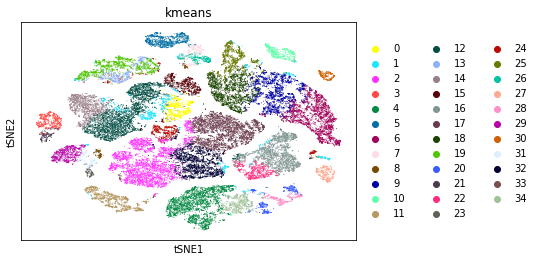

CPU times: user 16.3 s, sys: 213 ms, total: 16.5 s
Wall time: 1.56 s


In [20]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

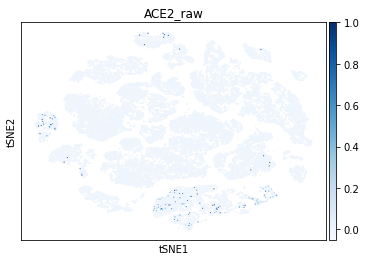

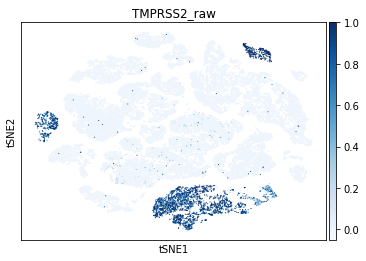

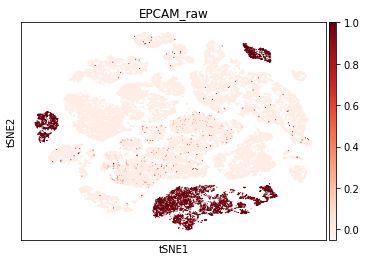

CPU times: user 1.16 s, sys: 6.82 ms, total: 1.17 s
Wall time: 1.16 s


In [21]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

In [22]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 28.2 s, sys: 903 ms, total: 29.1 s
Wall time: 28.3 s


In [23]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 7min 12s, sys: 5min 26s, total: 12min 39s
Wall time: 54.9 s


In [24]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 16.3 s, sys: 116 ms, total: 16.5 s
Wall time: 16.4 s


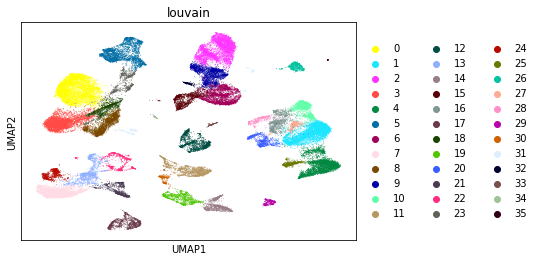

CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 1.35 s


In [25]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

In [26]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 16.6 s, sys: 169 ms, total: 16.7 s
Wall time: 16.7 s


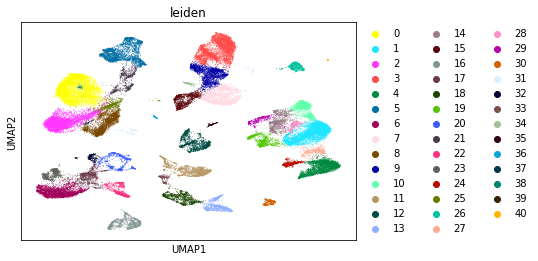

CPU times: user 1.45 s, sys: 11.4 ms, total: 1.46 s
Wall time: 1.46 s


In [27]:
%%time
# Plot
sc.pl.umap(adata, color=["leiden"])

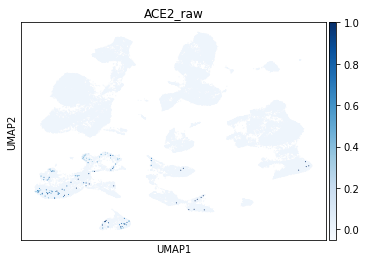

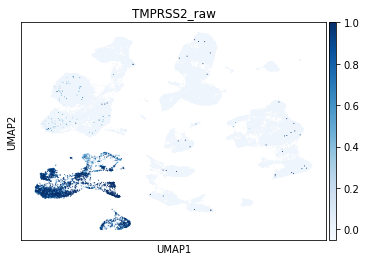

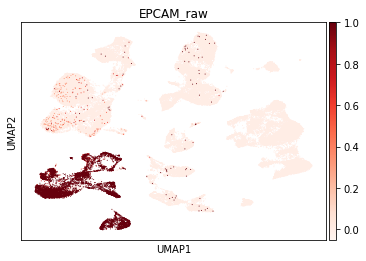

CPU times: user 1.28 s, sys: 5.64 ms, total: 1.29 s
Wall time: 1.29 s


In [28]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest', method='logreg')

CPU times: user 44min 54s, sys: 31min 1s, total: 1h 15min 56s
Wall time: 1min 39s


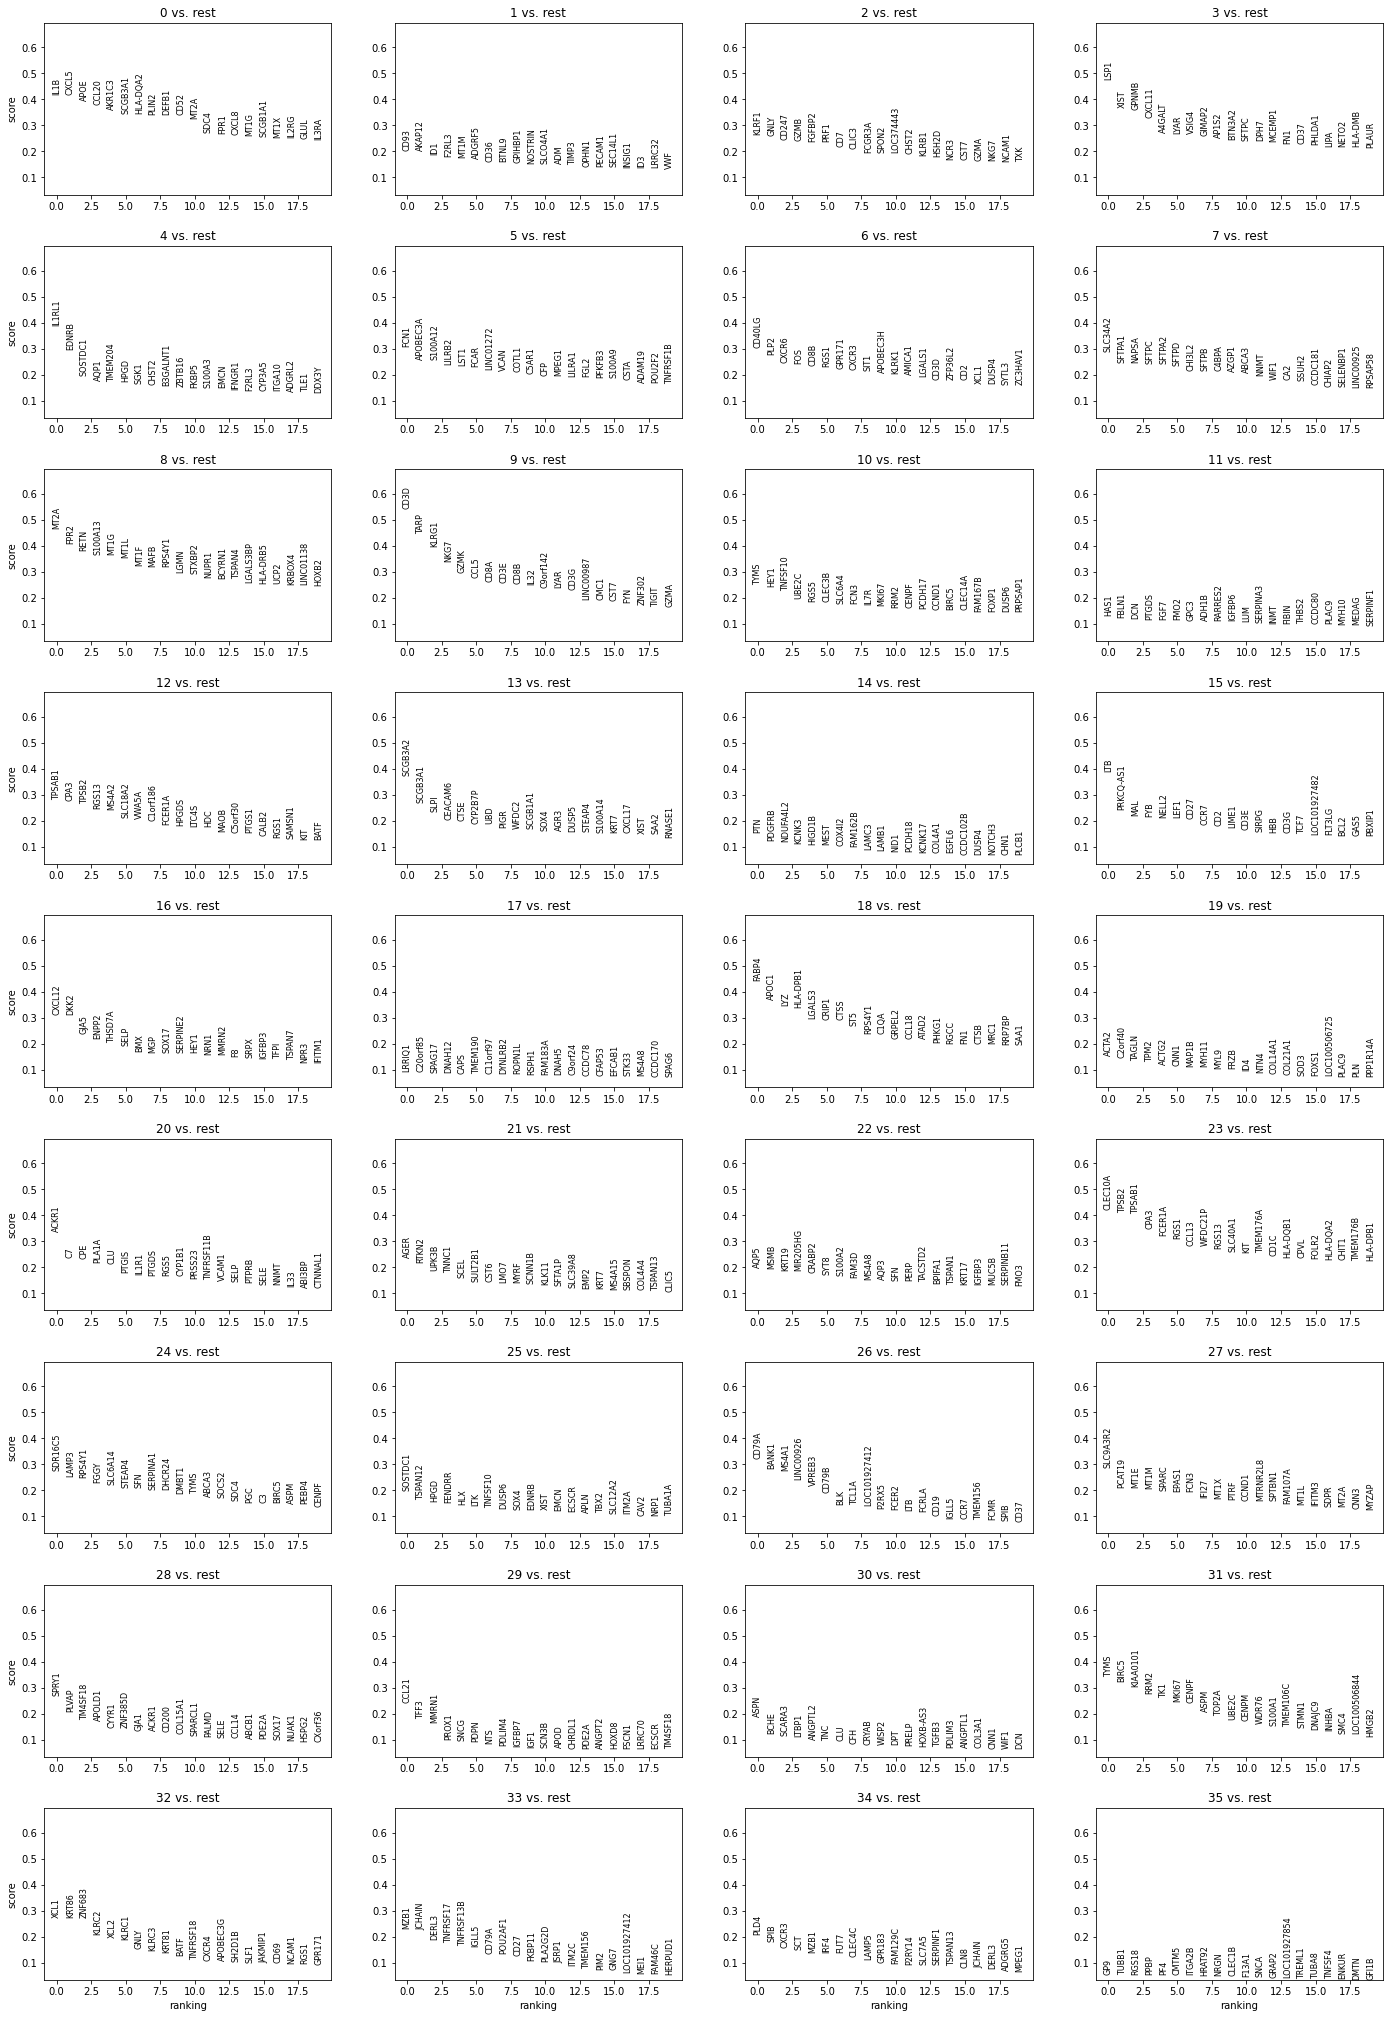

CPU times: user 7.66 s, sys: 474 ms, total: 8.13 s
Wall time: 8.13 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 175 ms, sys: 8.49 ms, total: 184 ms
Wall time: 181 ms


In [ ]:
adata=adata.copy()
scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent

In [33]:
%%time
#sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 1min 41s, sys: 2min 6s, total: 3min 47s
Wall time: 21.3 s


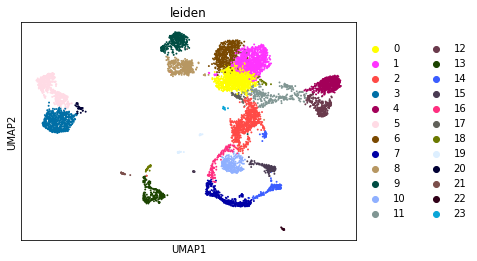

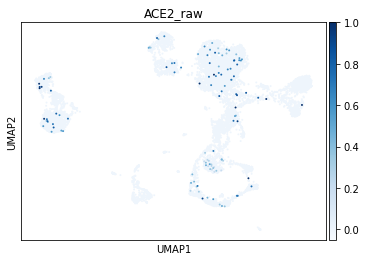

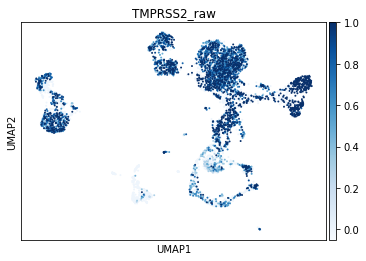

CPU times: user 978 ms, sys: 29.9 ms, total: 1.01 s
Wall time: 1 s


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 22.522207975387573


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 858.2612545490265
